<p align="center"> <img src="https://scholarlyoa.com/wp-content/uploads/2020/01/spam-email.png" width="500"> </p>  

# A simple method to filter spam
## Using feature engineering 

Email addresses and phones are targeted by these useless and sometimes dangerous messages. Spam messages lead to fraud, let alone all the waste of resources [[1](https://www.m3aawg.org/for-the-industry/email-metrics-report)].   

In the literature, filtering junk mail has been tackled in different ways. Machine learning-based techniques are largely used, and allow good performance in general. When I considered the spam filtering issue, the first thing I did was to read one (of too many...) messages I received lately.  
The message was an sms (text message) in french about some random unique offer that will expire soon, with a lot of exclamation marks and the usual formatting of good old spams. I realized that I categorized this message as spam, almost immediately after I saw it. Another thing was that, regardless of the language, I seem to look for the same characteristics every time I got spam.  
> In fact, I don't read the content of the message!  

What makes the human analysis quick is its simplicity. The KISS principle at its finest.
<p align="center"> <img src="http://bmig.co.uk/wp-content/uploads/2015/10/kiss-848x450.jpg" width="500"> </p>  
In this article, I will design a spam filter, based on a rather simple approach. The algorithm will not contain any complex natural language processing but will provide good results. The trick is the use of feature engineering.

## What is feature engineering?  
Using topic knowledge, we create, combine, select and/or modify the data features to obtain a less complex problem that could be solved using machine learning algorithms. A comprehensive explanation of feature engineering is presented by Jason Brownlee in his blog [Machine Learning Mastery](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/).  

## 1st step: Get some data, and explore it
We will need labeled data of spam messages to train and evaluate machine learning algorithms. Data from [UCI Machine Learning Repository](https://archive-beta.ics.uci.edu/ml/datasets/228) contains 5574 labeled text message (sms). It is a good quality dataset developped and published by Almeida, Tiago in 2012.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
import urllib.request
from zipfile import ZipFile
# Setting plots parameters
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.facecolor'] = '#00000000'
import warnings
warnings.filterwarnings("ignore")
from numpy.random import seed
seed(1) # in order to get the same results in every execution

In [2]:
# download data from UCI
# ref https://archive-beta.ics.uci.edu/ml/datasets/228
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
urllib.request.urlretrieve(url, 'sms_spam.zip')
# extract file
with ZipFile('sms_spam.zip', 'r') as zipObj:
   zipObj.extract('SMSSpamCollection')

In [3]:
data_raw = pd.read_csv('SMSSpamCollection',sep='\t',names=['Category','Message'])
data_raw['Category']=data_raw['Category'].astype('category') 
data_raw['Category_num'] = data_raw['Category'].cat.codes # one hot encoding for spam/ham

Now that the data is ready for use, let's do a quick exploratory analysis. First, we display the columns and their respective data types:

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Category      5572 non-null   category
 1   Message       5572 non-null   object  
 2   Category_num  5572 non-null   int8    
dtypes: category(1), int8(1), object(1)
memory usage: 54.6+ KB


Here is a sample of the data:

In [5]:
data_raw.head(5)

,Category,Message,Category_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


The category 1 refers to spam messages. Let's see how balanced is the dataset. 

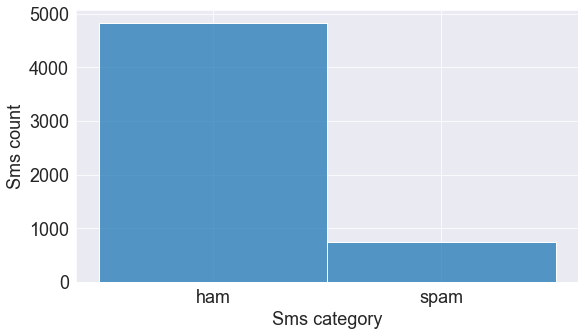

In [6]:
matplotlib.rcParams['figure.figsize'] = (9, 5)
fig = sns.histplot(data_raw['Category']);
fig.set(ylabel = 'Sms count', xlabel = 'Sms category', Title='');

The dataset contains fewer spam messages than regular messages. This could affect the training and must be considered when we will split data into training and testing sets. The choice of evaluation metrics must take into account this property.  

In [7]:
data_raw.groupby('Category')['Message'].count()/len(data_raw)

Category
ham     0.865937
spam    0.134063
Name: Message, dtype: float64

Based on this count, we can define the baseline accuracy for the classification. If a classifier predict non-spam for all the messages, we will obtain 86.6% accuracy.

## Creating new features  
We need more insight into spam messages. Let's display a sample: 

In [8]:
data_raw[data_raw['Category']=='spam'].sample(5)['Message'].values

array(['Marvel Mobile Play the official Ultimate Spider-man game (£4.50) on ur mobile right now. Text SPIDER to 83338 for the game & we ll send u a FREE 8Ball wallpaper',
       'Thank you, winner notified by sms. Good Luck! No future marketing reply STOP to 84122 customer services 08450542832',
       'Free msg. Sorry, a service you ordered from 81303 could not be delivered as you do not have sufficient credit. Please top up to receive the service.',
       'Thanks for your ringtone order, ref number R836. Your mobile will be charged £4.50. Should your tone not arrive please call customer services on 09065069154',
       'PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points. Call 08715203685 Identifier Code:4xx26 Expires 13/10/04'],
      dtype=object)

We can observe the following elements in these messages:
- Numbers (phone numbers, payments, reference numbers, etc)
- Lots of symbols and punctuations
- More capital letters than needed ...

To quantify those observations, let's define the following functions: 

In [9]:
lowercase ='abcdefghijklmnopqrstuvwxyz'
uppercase ='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
symbols='#!/\$%?&*()_+-^[]{|}><~;:.,»«@£="'+"'"
numbers='0123456789'

def lower_score(text):
    # returns the ratio of lower case letters with respect to the message length
    return sum([char_ in lowercase for char_ in text])/len(text)

def upper_score(text):
    # returns the ratio of upper case letters with respect to the message length
    return sum([char_ in uppercase for char_ in text])/len(text)

def symbol_score(text):
    # returns the ratio of symbols and ponctuations with respect to the message length
    return sum([char_ in symbols for char_ in text])/len(text)

def number_score(text):
    # returns the ratio of numbers with respect to the message length
    return sum([char_ in numbers for char_ in text])/len(text)

def space_score(text):
    # returns the ratio of spaces and ponctuations with respect to the message length
    return sum([char_ in ' ' for char_ in text])/len(text)

def length(text):
    # returns the length of the message
    return len(text)

Using these functions, we create new columns (features).

In [10]:
data_raw['lower_score'] = data_raw['Message'].apply(lower_score)
data_raw['upper_score'] = data_raw['Message'].apply(upper_score)
data_raw['number_score'] = data_raw['Message'].apply(number_score)
data_raw['symbol_score'] = data_raw['Message'].apply(symbol_score)
data_raw['space_score'] = data_raw['Message'].apply(space_score)
data_raw['length'] = data_raw['Message'].apply(length)

Let's look at the results:

In [12]:
data_raw.sample(5)

,Category,Message,Category_num,lower_score,upper_score,number_score,symbol_score,space_score,length
1331,ham,"Aight no rush, I'll ask jay",0,0.666667,0.074074,0.000000,0.074074,0.185185,27
1912,ham,Lol grr my mom is taking forever with my presc...,0,0.750000,0.032609,0.010870,0.032609,0.173913,92
5196,spam,Spook up your mob with a Halloween collection ...,1,0.600000,0.073333,0.120000,0.020000,0.186667,150
5497,spam,"SMS SERVICES. for your inclusive text credits,...",1,0.537975,0.151899,0.113924,0.063291,0.132911,158
1574,spam,SMS AUCTION - A BRAND NEW Nokia 7250 is up 4 a...,1,0.382550,0.268456,0.114094,0.053691,0.181208,149


Standardizing the features prevent numerical issues when using gradient descent or iterative methods. 

In [13]:
# standardize all newly created features
std_g = np.std(data_raw['length'])
mean_g = np.mean(data_raw['length'])
data_raw['length_std'] = (data_raw['length']-mean_g)/std_g

std_l = np.std(data_raw['lower_score'])
mean_l = np.mean(data_raw['lower_score'])
data_raw['lower_score_std'] = (data_raw['lower_score']-mean_l)/std_l

std_c = np.std(data_raw['upper_score'])
mean_c = np.mean(data_raw['upper_score'])
data_raw['upper_score_std'] = (data_raw['upper_score']-mean_c)/std_c

std_n = np.std(data_raw['number_score'])
mean_n = np.mean(data_raw['number_score'])
data_raw['number_score_std'] = (data_raw['number_score']-mean_n)/std_n

std_s = np.std(data_raw['symbol_score'])
mean_s = np.mean(data_raw['symbol_score'])
data_raw['symbol_score_std'] = (data_raw['symbol_score']-mean_s)/std_s

std_p = np.std(data_raw['space_score'])
mean_p = np.mean(data_raw['space_score'])
data_raw['space_score_std'] = (data_raw['space_score']-mean_p)/std_p

We can get an intuition on how effective the newly-created features can be in classifying messages by comparing their averages for spam and ham messages:

In [14]:
data_raw.groupby('Category').mean()

,Category_num,lower_score,upper_score,number_score,symbol_score,space_score,length,length_std,lower_score_std,upper_score_std,number_score_std,symbol_score_std,space_score_std
Category,,,,,,,,,,,,,
ham,0,0.693129,0.058196,0.004241,0.061730,0.181630,71.482487,-0.150281,0.129469,-0.064744,-0.304418,0.040955,0.065530
spam,1,0.563916,0.110913,0.116537,0.044052,0.164493,138.670683,0.970690,-0.836261,0.418195,1.966286,-0.264537,-0.423267


The average value of each new feature is different for spam and non-spam messages. This means that we could differentiate the messages using those properties.  
A visual (and easier) way to verify our hypothesis can be achieved using scatter plots

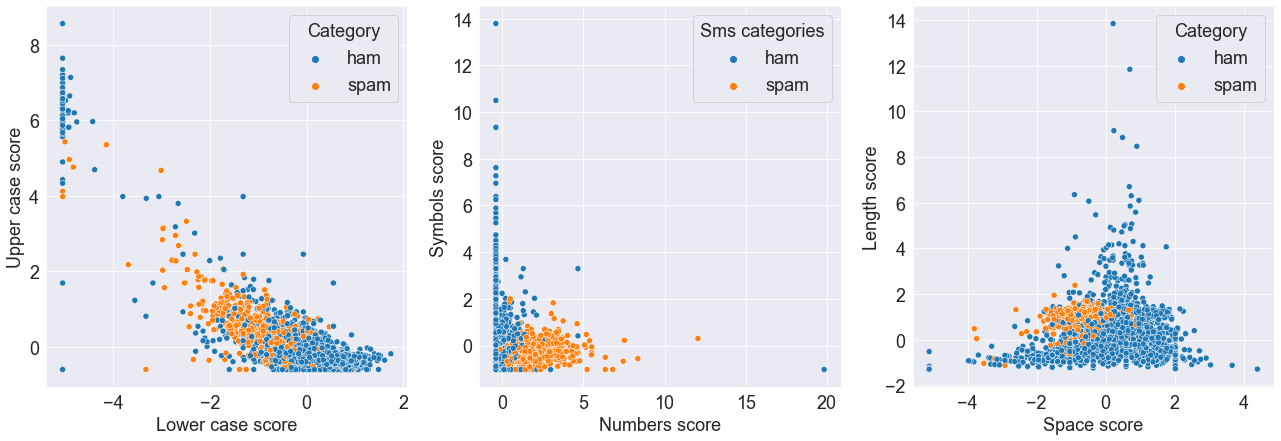

In [23]:
matplotlib.rcParams['figure.figsize'] = (22, 7)
plt.subplot(131);
fig = sns.scatterplot(x='lower_score_std',y='upper_score_std',hue='Category',data=data_raw);
fig.set(ylabel = 'Upper case score', xlabel = 'Lower case score', Title='');
#fig.legend(title='Sms categories');
plt.subplot(132);
fig = sns.scatterplot(x='number_score_std',y='symbol_score_std',hue='Category',data=data_raw);
fig.set(ylabel = 'Symbols score', xlabel = 'Numbers score', Title='');
fig.legend(title='Sms categories');
plt.subplot(133);
fig = sns.scatterplot(x='space_score_std',y='length_std',hue='Category',data=data_raw);
fig.set(ylabel = 'Length score', xlabel = 'Space score', Title='');
#fig.legend(title='Sms categories');


The boundary between the spam/non-spam messages is easy to determin visually, using these features. The classification problem doesn't seem to be complex. We expect good results using basic techniques.

Well, it is time to try some machine learning algorithms!

## Classification of spam messages using machine learning algorithms
The data is split into three sets: training, validation, and a test set. The first will be used to fit the algorithms to the data. Validation data will be used to tune hyperparameters (if required). The test set will be used to evaluate the accuracy of the methods on unseen messages.

In [24]:
from sklearn.model_selection import train_test_split
trainval_data, test_data = train_test_split(data_raw,test_size=0.2)
train_data, val_data = train_test_split(trainval_data,test_size=0.25)

Let's verify if the subsets contain the same ratio of spam/ham messages:

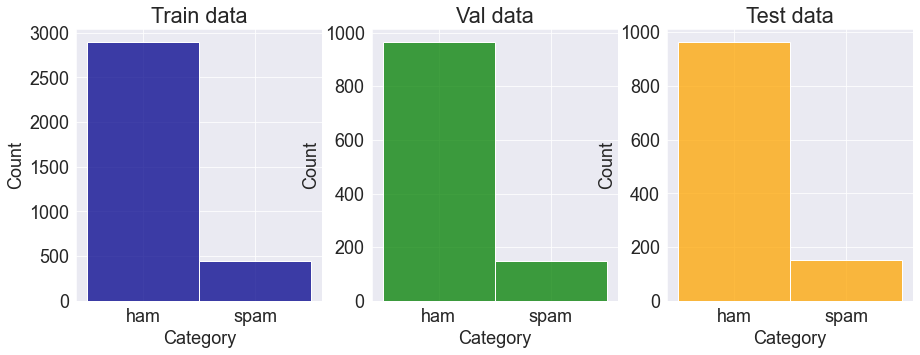

In [25]:
# check if the split is well distributed
matplotlib.rcParams['figure.figsize'] = (15, 5)
plt.subplot(131);
fig = sns.histplot(train_data['Category'],color='darkblue');
fig.set_title('Train data');
plt.subplot(132);
fig= sns.histplot(val_data['Category'],color='green');
fig.set_title('Val data') ;
plt.subplot(133);
fig = sns.histplot(test_data['Category'],color='orange');
fig.set_title('Test data');


It turns out that `train_test_split` keeps the original distribution of the data. This is a very important point when creating training, validation, and test splits.  
  
Now, we specify the features and labels for each set:

In [26]:
# create train val, and test sets
# input columns (features)

in_cols = ['lower_score_std','upper_score_std','number_score_std','symbol_score_std','length_std','space_score_std']


train_features =train_data[in_cols]
train_labels = train_data['Category_num']


val_features =val_data[in_cols]
val_labels = val_data['Category_num']

test_features =test_data[in_cols]
test_labels = test_data['Category_num']

### Logistic regression
The first algorithm we will train is one of the most basic methods of classification: **logistic regression**, using `Sci-Kit learn` library. The maximal number of iteration `max_iter` is a hyperparameter that can affect the generalization capacity of the classifier (and prevent overfitting). We can select the best value using a loop.

In [42]:
# logistic regression 
from sklearn.linear_model import LogisticRegression 
val_acc=[]
for max_iter in range(1,2000):
    logistic_classifier_i = LogisticRegression(max_iter=max_iter)
    logistic_classifier_i.fit(train_features,train_labels);
    val_acc.append(logistic_classifier_i.score(val_features,val_labels))

In [43]:
# choose the classifier with the maximal accuracy
max_iter_opt = np.argmax(val_acc)+1
logistic_classifier = LogisticRegression(max_iter=max_iter_opt)
logistic_classifier.fit(train_features,train_labels);

First, let's see how the logistic regression classifier performs on the training data:

In [44]:
print('Accuracy on training set: {:.2f}'.format(logistic_classifier.score(train_features,train_labels)))

Accuracy on training set: 0.96


96% is better than the baseline accuracy (86.6%), but the important information to get is how the classifier performs on new data. 

In [46]:
print('Accuracy on testing set: {:.2f}'.format(logistic_classifier.score(test_features,test_labels)))

Accuracy on testing set: 0.97


An accuracy of 97% looks like a good result. However, the dataset is not balanced, so accuracy can be misleading. One way to tackle this problem is to choose metrics that are adapted to unbalanced data. **Recall** and **Precision** will be used in our analysis. More details are available [here](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall).

In [47]:
from sklearn.metrics import recall_score, precision_score
test_pred = logistic_classifier.predict(test_features)
print("Recall score for logistic regression: {:.2f}".format(recall_score(test_labels,test_pred)))
print("Precision score for logistic regression: {:.2f}".format(precision_score(test_labels,test_pred)))

Recall score for logistic regression: 0.79
Precision score for logistic regression: 0.94


The regression coefficients or weights can give an intuition about which features are the most important. This method works only if the feature values are in the same range.

In [48]:
print('Classifier coefficients (weights)')
logistic_classifier.coef_

Classifier coefficients (weights)


array([[-0.26146501, -0.12987742,  1.9049279 , -0.47917092,  0.51059734,
        -0.45687447]])

### K-nearest neighbors
Based on the same library and methodology, we solve the problem using the **KNN** algorithm. This algorithm has a hyperparameter `n_neighbor` which refers to the number of neighbors that are used to predict the output. 

In [24]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
classifiers = []
accuracies = []
for n_neighbors in range(1,21):
    KNN_classifier_i = KNeighborsClassifier(n_neighbors=n_neighbors)
    KNN_classifier_i.fit(train_features,train_labels);
    acc_val = KNN_classifier_i.score(val_features,val_labels)
    classifiers.append([KNN_classifier_i, n_neighbors])
    accuracies.append(acc_val)
# choose the classifier with the maximal accuracy
accuracies_max = np.argmax(accuracies)
KNN_classifier = classifiers[accuracies_max][0]
print('best n_neighbors = ',classifiers[accuracies_max][1])

best n_neighbors =  7


In [25]:
acc_test = KNN_classifier.score(test_features,test_labels)
print('Accuracy on testing set for KNN: {:.2f}'.format(acc_test))
test_pred = KNN_classifier.predict(test_features)
print("Recall score for KNN: {:.2f}".format(recall_score(test_labels,test_pred)))
print("Precision score for KNN: {:.2f}".format(precision_score(test_labels,test_pred)))

Accuracy on testing set for KNN: 0.99
Recall score for KNN: 0.90
Precision score for KNN: 0.99


The results obtained using KNN are better than logistic regression, in terms of accuracy and recall. 

### Naive Bayes classification
The third method we will test is based on Bayes theory. Many real world applications for spam filtering are based on this method. We will not perform hyperparameters tunning with this method.

In [26]:
# naive bayes
from sklearn.naive_bayes import GaussianNB 
NaiveBayes_classifier = GaussianNB()
NaiveBayes_classifier.fit(train_features,train_labels);

In [27]:
acc_test = NaiveBayes_classifier.score(test_features,test_labels)
print('Accuracy on testing set for Naive Bayes classifier: {:.2f}'.format(acc_test))
test_pred = NaiveBayes_classifier.predict(test_features)
print("Recall score for Naive Bayes classifier: {:.2f}".format(recall_score(test_labels,test_pred)))
print("Precision score for Naive Bayes classifier: {:.2f}".format(precision_score(test_labels,test_pred)))

Accuracy on testing set for Naive Bayes classifier: 0.98
Recall score for Naive Bayes classifier: 0.86
Precision score for Naive Bayes classifier: 0.98


### Decision trees
Decision trees are simple to implement and can be very efficient in classification problems. Decision trees can be tuned using multiple hyperparameters. In this study, we will tune `max_depth` parameter.

In [28]:
# decision trees
from sklearn.tree import DecisionTreeClassifier
classifiers = []
accuracies = []
for max_depth in range(1,50):
    DT_classifier_i = DecisionTreeClassifier(max_depth = max_depth, random_state=42)
    DT_classifier_i.fit(train_features,train_labels);
    acc_val = DT_classifier_i.score(val_features,val_labels)
    classifiers.append([DT_classifier_i, max_depth])
    accuracies.append(acc_val)
# choose the classifier with the maximal accuracy
accuracies_max = np.argmax(accuracies)
DT_classifier = classifiers[accuracies_max][0]
print('best max_depth = ',classifiers[accuracies_max][1])

best max_depth =  7


In [29]:
acc_test = DT_classifier.score(test_features,test_labels)
print('Accuracy on testing set for Decision tree classifier: {:.2f}'.format(acc_test))
test_pred = DT_classifier.predict(test_features)
print("Recall score for decicion tree classifier: {:.2f}".format(recall_score(test_labels,test_pred)))
print("Precision score for decicion tree classifier: {:.2f}".format(precision_score(test_labels,test_pred)))

Accuracy on testing set for Decision tree classifier: 0.97
Recall score for decicion tree classifier: 0.89
Precision score for decicion tree classifier: 0.89


### Feed forward neural network 
The last method we will test, is neural feed forward networks. We will implement a simple network of one hidden layers of 10 neurons and one output neuron using sigmoid activation (appropriate for binary classification). Tensorflow platform will be used, with KERAS API. 

In [30]:
# a basic feed forward neural network using Keras/Tensorflow

# building the net using keras
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(10 , activation='relu' , input_dim=len(in_cols))) #1st hidden layer
network.add(layers.Dense(1, activation='sigmoid')) # outplut layer

network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc','Precision','Recall'])

# Training 
n_epochs =200
result = network.fit(train_features,train_labels,epochs = n_epochs,verbose=0,validation_data= (val_features,val_labels),shuffle=False)

In [31]:
# to avoid overfitting, choose the number of epochs that maximize the validation accuracy
n_epochs_opt = np.argmax(result.history['val_acc'])+1
print('Optimal number of epochs = ', n_epochs_opt)
# we train the network with the optimal number of epochs
nn_classifier = models.Sequential()
nn_classifier.add(layers.Dense(10 , activation='relu' , input_dim=len(in_cols))) #1st hidden layer
nn_classifier.add(layers.Dense(1, activation='sigmoid')) # outplut layer
nn_classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc','Precision','Recall'])

# Training 
result = nn_classifier.fit(train_features,train_labels,epochs = n_epochs_opt,verbose=0,validation_data= (val_features,val_labels),shuffle=False)

Optimal number of epochs =  168


In [32]:
# show the metrics on the test data
nn_test_outputs = np.round(nn_classifier.predict(test_features))
test_preds = np.reshape(nn_test_outputs,(1,-1))[0]
acc_test = np.sum(test_preds== test_labels)/len(test_labels)
print('Accuracy on testing set for Neural Network: {:.2f}'.format(acc_test))
print("Recall score for Neural Network: {:.2f}".format(recall_score(test_labels,test_preds)))
print("Precision score for Neural Network: {:.2f}".format(precision_score(test_labels,test_preds)))

Accuracy on testing set for Neural Network: 0.98
Recall score for Neural Network: 0.90
Precision score for Neural Network: 0.97


## Comparison of the metrics
In this table are shown the accuracy, recall, precision for all the classification methods.

| Algorithm       | Accuracy     | Recall     | Precision     |
| :---------------- | :-------------: | --------------: |  --------------: |
|  Logistic regression | 0.97   | 0.79    | 0.94    |
| K-Nearest neighbors | 0.99   | 0.90    | 0.99    |
| Naive Bayes | 0.98  | 0.86    | 0.98    |
| Decision trees | 0.97   | 0.89    | 0.89    |
| FF Neural network   | 0.98 | 0.90 |0.98 |  
  
All the methods show good performance, with regards to the metrics. The neural network which is more complex to train and implement shows a better performance. It turns out that the problem is numerically simple, so using complex algorithm doesn't improve significantly the performance. Each method has pros and cons. The choice depends ultimately on the end user and the environment.   

## Summary and future work  
In this notebook, the problem of filtering SMS spam has been tackled using a feature engineering approach. We have developed new features, based on simple observations:
* The ratio of capital letters
* The ratio of numbers and symbols  
  
Using these features, we implemented multiple machine learning classification algorithms. The tests showed good results, while the problem formulation remained simple.
In the future, we will apply this approach to more complex text classification problems. We will focus also on hyperparameters tunning and will test other machine learning techniques.

## References and links  
- Machine learning mastery blog by Jason Brownlee [https://machinelearningmastery.com]
- UCI Machine Learning Repository [https://archive-beta.ics.uci.edu/ml/datasets/228]
- Google machine learning crash course [https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall]
- My Github [https://github.com/zaitrik]
- My LinkedIn [https://www.linkedin.com/in/mounir-kara-zaitri-a01a00208/]